## from https://web.stanford.edu/~boyd/papers/admm/

# Code

### required:

download `LBFGS-B` from https://www.mathworks.com/matlabcentral/fileexchange/15061-matlab-interface-for-l-bfgs-b

unzip the file

add `#include <cstring>` in the file `matlabstring.cpp`

modify the `Makefile` as follows (adjust the `MATLAB_HOME`):

```make
# Linux settings.
MEX         = mex
MEXSUFFIX   = mexglx
MATLAB_HOME = /usr/local/MATLAB/R2021a
CXX         = g++
F77         = gfortran
CFLAGS      = -O3 -fPIC -pthread
FFLAGS      = -O3 -fPIC -fexceptions

TARGET = lbfgsb.$(MEXSUFFIX)
OBJS   = solver.o matlabexception.o matlabscalar.o matlabstring.o   \
         matlabmatrix.o arrayofmatrices.o program.o matlabprogram.o \
         lbfgsb.o

CFLAGS += -Wall -ansi -DMATLAB_MEXFILE

all: $(TARGET)

%.o: %.cpp
        $(CXX) $(CFLAGS) -I$(MATLAB_HOME)/extern/include -o $@ -c $^

%.o: %.f
        $(F77) $(FFLAGS) -o $@ -c $^

$(TARGET): $(OBJS)
        $(MEX) -cxx CXX=$(CXX) CC=$(CXX) FC=$(FCC) LD=$(CXX) -lgfortran -lm \
        -O -output $@ $^

clean:
        rm -f *.o $(TARGET)
```

copy the generated `lbfgsb.mexa64` file into this directory


In [1]:
code = grabcode("https://web.stanford.edu/~boyd/papers/admm/logreg-l1/distr_l1_logreg.html")


code =

    'function [z, history] = distr_l1_logreg(A, b, mu, N, rho, alpha)
     % distr_l1_logreg   Solve distributed L1 regularized logistic regression 
     %
     % [x, history] = distr_l1_logreg(A, b, mu, N, rho, alpha)
     %
     % solves the following problem via ADMM:
     %
     %   minimize   sum( log(1 + exp(-b_i*(a_i'w + v)) ) + m*mu*norm(w,1)
     %
     % where A is a feature matrix and b is a response vector. The scalar m is
     % the number of examples in the matrix A. 
     %
     % This solves the L1 regularized logistic regression problem. It uses
     % a custom Newton solver for the x-step. This version solves a distributed
     % version of L1 regularized logistic regression.
     %
     % The solution is returned in the vector x = (v,w).
     %
     % history is a structure that contains the objective value, the primal and 
     % dual residual norms, and the tolerances for the primal and dual residual 
     % norms at each iteration.
     %
     % N is the 

In [2]:
%%file distr_l1_logreg.m

function [z, history] = distr_l1_logreg(A, b, mu, N, rho, alpha)
% distr_l1_logreg   Solve distributed L1 regularized logistic regression
%
% [x, history] = distr_l1_logreg(A, b, mu, N, rho, alpha)
%
% solves the following problem via ADMM:
%
%   minimize   sum( log(1 + exp(-b_i*(a_i'w + v)) ) + m*mu*norm(w,1)
%
% where A is a feature matrix and b is a response vector. The scalar m is
% the number of examples in the matrix A.
%
% This solves the L1 regularized logistic regression problem. It uses
% a custom Newton solver for the x-step. This version solves a distributed
% version of L1 regularized logistic regression.
%
% The solution is returned in the vector x = (v,w).
%
% history is a structure that contains the objective value, the primal and
% dual residual norms, and the tolerances for the primal and dual residual
% norms at each iteration.
%
% N is the number of subsystems to use to split the examples. This code
% will (serially) solve N x-updates with m / N examples per subsystem.
% Therefore, the number of examples, m, should be divisible by N. No error
% checking is done.
%
% rho is the augmented Lagrangian parameter.
%
% alpha is the over-relaxation parameter (typical values for alpha are
% between 1.0 and 1.8).
%
% This example requires the "MATLAB Interface for L-BFGS-B" and L-BFGS-B
% installed. These can be acquiured at
% http://www.cs.ubc.ca/~pcarbo/lbfgsb-for-matlab.html.
%
%
% More information can be found in the paper linked at:
% http://www.stanford.edu/~boyd/papers/distr_opt_stat_learning_admm.html
%


t_start = tic;

%% Global constants and defaults

QUIET    = 0;
MAX_ITER = 1000;
ABSTOL   = 1e-4;
RELTOL   = 1e-2;

%% Preprocessing

[m, n] = size(A);
m = m / N;  % should be divisible

%% ADMM solver

x = zeros(n+1,N);
z = zeros(n+1,N);
u = zeros(n+1,N);


if ~QUIET
    fprintf('%3s\t%10s\t%10s\t%10s\t%10s\t%10s\t%10s\n', 'iter', '# bfgs', ...
      'r norm', 'eps pri', 's norm', 'eps dual', 'objective');
end
p = size(z,1);
C = [-b -A]';

global BFGS_ITERS;  % global variable to keep track of bfgs iterations
bfgs_iters = zeros(N,1);

for k = 1:MAX_ITER

    % serial x-update
    for i = 1:N,
        K = C(:,1+(i-1)*m:i*m)';
        x(:,i) = bfgs_update(K, u(:,i), z(:,i), rho, N, x(:,i));
        bfgs_iters(i) = BFGS_ITERS;
    end

    % z-update with relaxation
    zold = z;
    x_hat = alpha*x + (1-alpha)*zold;
    ztilde = mean(x_hat + u,2);
    ztilde(2:end) = shrinkage( ztilde(2:end), (m*N)*mu/(rho*N) );

    z = ztilde*ones(1,N);

    % u-update
    u = u + (x_hat - z);

    % diagnostics, reporting, termination checks
    history.objval(k)  = objective(A, b, mu, x, z(:,1));

    history.r_norm(k)  = norm(x - z, 'fro');
    history.s_norm(k)  = norm(rho*(z - zold),'fro');

    history.LBFGS_iters(:,k) = bfgs_iters;

    history.eps_pri(k) = sqrt(p*N)*ABSTOL + RELTOL*max(norm(x,'fro'), norm(z,'fro'));
    history.eps_dual(k)= sqrt(p*N)*ABSTOL + RELTOL*norm(rho*u,'fro');

    if ~QUIET
        fprintf('%3d\t%10d\t%10.4f\t%10.4f\t%10.4f\t%10.4f\t%10.2f\n', k, sum(bfgs_iters), ...
            history.r_norm(k), history.eps_pri(k), ...
            history.s_norm(k), history.eps_dual(k), history.objval(k));
    end


    if history.r_norm(k) < history.eps_pri(k) && ...
       history.s_norm(k) < history.eps_dual(k)
        break;
    end
end

if ~QUIET
    toc(t_start);
end
z = z(:,1);
end

function obj = objective(A, b, mu, x, z)
    m = size(A,1);
    obj = sum(log(1 + exp(-A*z(2:end) -b*z(1)))) + m*mu*norm(z(2:end),1);
end

function [x t] = bfgs_update(C, u, z, rho, N, x0)
    % solve the x update
    %   minimize [ -logistic(x_i) + (rho/2)||x_i - z^k + u^k||^2 ]
    % via L-BFGS

    [m n] = size(C);

    auxdata{1} = C;
    auxdata{2} = z;
    auxdata{3} = u;
    auxdata{4} = rho;

    x = lbfgsb(x0, -Inf*ones(n,1), +Inf*ones(n,1), 'l2_log', 'l2_log_grad', auxdata, 'record_bfgs_iters');
end


function z = shrinkage(a, kappa)
    z = max(0, a-kappa) - max(0, -a-kappa);
end

Created file '/home/wenh06/Jupyter/wenhao/workspace/fl_seminar/code/boyd-admm/distr_l1_logreg.m'.


In [3]:
%%file l2_log.m

function val = l2_log(x, auxdata)
    C = auxdata{1};
    z = auxdata{2};
    u = auxdata{3};
    rho = auxdata{4};
    %N = auxdata{5};
    
    %m = size(C,1);
    val = sum(log(1 + exp(C*x))) + (1/2)*(x - z + u)'*rho*(x - z + u);
end

Created file '/home/wenh06/Jupyter/wenhao/workspace/fl_seminar/code/boyd-admm/l2_log.m'.


In [4]:
%%file l2_log_grad.m

function grad = l2_log_grad(x, auxdata)
    C = auxdata{1};
    z = auxdata{2};
    u = auxdata{3};
    rho = auxdata{4};
    %N = auxdata{5};
    
    %m = size(C,1);
    e2Cx = exp(C*x);
    grad = (C'*(e2Cx./(1 + e2Cx))) + rho*(x - z + u); %1/(m*N)* (C'*(e2Cx./(1 + e2Cx))) + rho*(x - z + u);
end

Created file '/home/wenh06/Jupyter/wenhao/workspace/fl_seminar/code/boyd-admm/l2_log_grad.m'.


In [5]:
%%file record_bfgs_iters.m

function record_bfgs_iters(t, f, x, auxdata)
    global BFGS_ITERS;
    BFGS_ITERS = t;
end

Created file '/home/wenh06/Jupyter/wenhao/workspace/fl_seminar/code/boyd-admm/record_bfgs_iters.m'.


# Example

In [6]:
eg_code = grabcode("https://web.stanford.edu/~boyd/papers/admm/logreg-l1/distr_l1_logreg_example.html")


eg_code =

    '% Distributed L1 regularized logistic regression
     % (compared against l1_logreg package)
     
     %% Generate problem data
     rand('seed', 0);
     randn('seed', 0);
     
     n = 200; 
     m = 200; 
     N = 100;
     
     w = sprandn(n, 1, 100/n);       % N(0,1), 10% sparse
     v = randn(1);                  % random intercept
     
     X0 = sprandn(m*N, n, 10/n);           % data / observations
     btrue = sign(X0*w + v);
     
     % noise is function of problem size use 0.1 for large problem
     b0 = sign(X0*w + v + sqrt(0.1)*randn(m*N, 1)); % labels with noise
     
     % packs all observations in to an m*N x n matrix
     A0 = spdiags(b0, 0, m*N, m*N) * X0;
     
     ratio = sum(b0 == 1)/(m*N);
     mu = 0.1*1/(m*N) * norm((1-ratio)*sum(A0(b0==1,:),1) + ratio*sum(A0(b0==-1,:),1), 'inf');
     
     x_true = [v; w];
     
     %% Solve problem
     
     [x history] = distr_l1_logreg(A0, b0, mu, N, 1.0, 1.0);
     
     %% Reporting
     
     K 

### Generate problem data

In [7]:
rand('seed', 0);
randn('seed', 0);

n = 200;
m = 200;
N = 100;

w = sprandn(n, 1, 100/n);       % N(0,1), 10% sparse
v = randn(1);                  % random intercept

X0 = sprandn(m*N, n, 10/n);           % data / observations
btrue = sign(X0*w + v);

% noise is function of problem size use 0.1 for large problem
b0 = sign(X0*w + v + sqrt(0.1)*randn(m*N, 1)); % labels with noise

% packs all observations in to an m*N x n matrix
A0 = spdiags(b0, 0, m*N, m*N) * X0;

ratio = sum(b0 == 1)/(m*N);
mu = 0.1*1/(m*N) * norm((1-ratio)*sum(A0(b0==1,:),1) + ratio*sum(A0(b0==-1,:),1), 'inf');

x_true = [v; w];

### Solve problem

In [8]:
[x history] = distr_l1_logreg(A0, b0, mu, N, 1.0, 1.0);

iter	    # bfgs	    r norm	   eps pri	    s norm	  eps dual	 objective
  1	      2034	   57.0681	    0.6804	   19.7440	    0.5849	  11824.14
  2	      1833	   26.5753	    0.5584	   28.1814	    0.8198	   9973.21
  3	      1773	   16.2131	    0.7186	   21.4621	    0.9342	   9219.04
  4	      1696	   11.9694	    0.8572	   15.0765	    1.0017	   8914.00
  5	      1661	    9.2421	    0.9576	   10.5568	    1.0475	   8782.13
  6	      1560	    7.2694	    1.0297	    7.5041	    1.0813	   8720.73
  7	      1513	    5.8004	    1.0819	    5.4344	    1.1076	   8690.23
  8	      1486	    4.6913	    1.1200	    3.9979	    1.1288	   8674.40
  9	      1424	    3.8447	    1.1482	    2.9738	    1.1462	   8665.95
 10	      1397	    3.1897	    1.1691	    2.2269	    1.1608	   8661.38
 11	      1359	    2.6766	    1.1846	    1.6725	    1.1730	   8658.87
 12	      1305	    2.2700	    1.1963	    1.2562	    1.1835	   8657.51
 13	      1255	    1.9447	    1.2050	    0.9416	    1.1924	   8656.76
 14	      1178	    

### Reporting

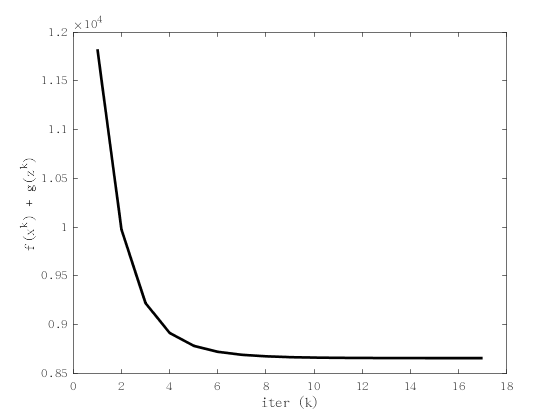

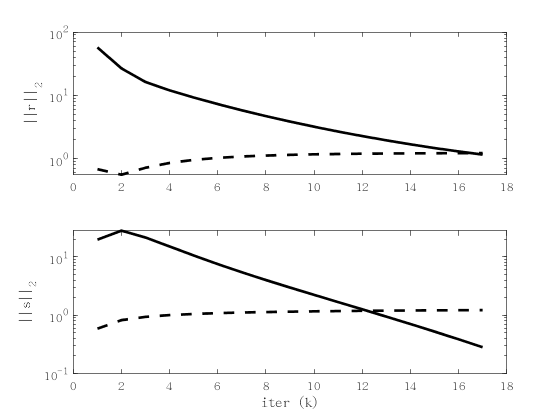

In [9]:
K = length(history.objval);

h = figure;
plot(1:K, history.objval, 'k', 'MarkerSize', 10, 'LineWidth', 2);
ylabel('f(x^k) + g(z^k)'); xlabel('iter (k)');

g = figure;
subplot(2,1,1);
semilogy(1:K, max(1e-8, history.r_norm), 'k', ...
    1:K, history.eps_pri, 'k--',  'LineWidth', 2);
ylabel('||r||_2');

subplot(2,1,2);
semilogy(1:K, max(1e-8, history.s_norm), 'k', ...
    1:K, history.eps_dual, 'k--', 'LineWidth', 2);
ylabel('||s||_2'); xlabel('iter (k)');